In [284]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy import control as ctrl
import random
from IPython.display import display


In [285]:
PATH = './AMAZON_FASHION.json.gz'
PATH_meta = './meta_AMAZON_FASHION.json.gz'

## MODULO 1
### Lector de datasets

In [286]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [287]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [288]:
df_meta.shape

(186637, 16)

In [289]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [290]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

Eliminamos las filas que tengan vacio una de estas columnas

In [291]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta.columns]

if existing_columns:
    for column in existing_columns:
        df_meta = df_meta[df_meta[column].astype(bool)]
    df_meta = df_meta.dropna(subset=existing_columns)

In [292]:
df_meta.shape

(12738, 16)

In [293]:
df_meta.head()

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Envirosax Kids Series Jessie & Lulu,Envirosax,[Product Dimensions:\n \n17...,"25,698,912inClothing,ShoesJewelry(",5 star,8037200124,NaN,NaN,[Educating the next generation in the responsi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Envirosax Greengrocer Series Bag 7 Guava,Envirosax,[Product Dimensions:\n \n18...,"25,850,143inClothing,ShoesJewelry(",5 star,8037200221,NaN,NaN,[Envirosax Greengrocer - a range of plain colo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,"X. L. Carbon Fiber Money Clip, made in the USA",Roar Carbon,"[Real Carbon Fiber, Made in USA, 5 year warran...","3,725,957inClothing,Shoesamp;Jewelry(",5 star,9654263246,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[When you pull out your extra large carbon fib...,$14.99,"[B07CQ3KY5B, B014TEOG3O, B078429G6J, B01FRG9Z7...",NaN,NaN,NaN,NaN,NaN
18,Shimmer Anne Shine Clip On Costume/Halloween C...,Shimmer Anne Shine,[Shimmer Anne Shine Clip On Costume/Halloween ...,"468,314inClothing,ShoesJewelry(",5 star,B00004T3SN,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,"[A fun addition to any costume party, play, or...",$6.99,"[B00Q5RRK78, B00RN3JILE, B00PMUTNOM, B01KA5PTY...",[B01KA5PTYG],NaN,NaN,NaN,NaN


Text(0, 0.5, 'Count')

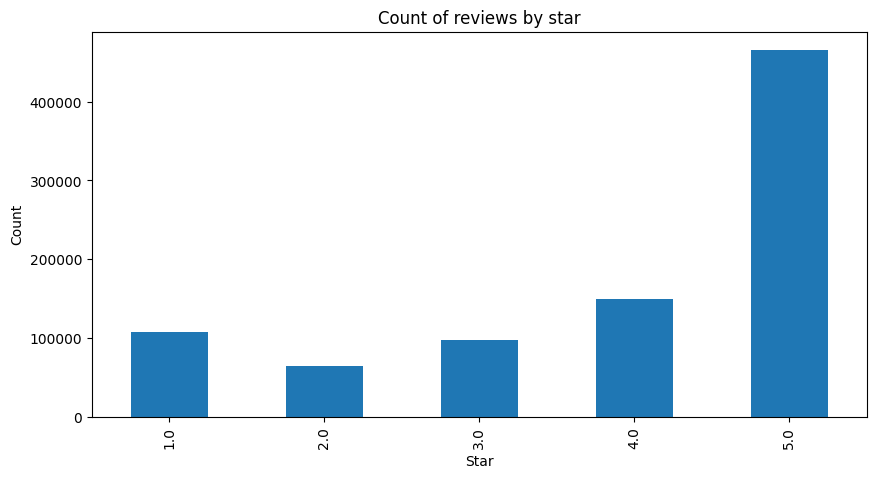

In [294]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")

notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [295]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## MODULO 2
### Rating Score
calculamos el overall mean

In [296]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


agregamos la columnas id al dataframe df_meta

In [297]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos la muestra para facilitar el procesamiento 

In [298]:
CANTIDAD = 10000

In [299]:
df_meta_cortado = df_meta.head(CANTIDAD)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [300]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_meta_cortadoFrame 'df_meta_cortado'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


C:\Users\coraj\AppData\Local\Temp\ipykernel_20708\1163952785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


La matriz vecs contiene las puntuaciones TF-IDF ( Frecuencia de Término - Frecuencia Inversa de Documento) para cada palabra en cada documento. Las puntuaciones TF-IDF representan la importancia de una palabra para un documento en la colección.

In [301]:

vec = TfidfVectorizer()
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(10000, 30648)

## Modulo 3
### Similarity Score

Esto significa que tienes 10000 documentos (las filas del DataFrame df_meta_cortado) y 22929 palabras únicas en todos los documentos (las características).

calcular la similitud del coseno entre cada par de vectores en vecs

Su valor varía de -1 (vectores completamente opuestos) a 1 (vectores idénticos), con 0 indicando ortogonalidad (vectores perpendiculares).

In [302]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.0379272 , 0.04252424, ..., 0.00757512, 0.00755539,
        0.        ],
       [0.0379272 , 1.        , 0.5591654 , ..., 0.00506212, 0.00504893,
        0.        ],
       [0.04252424, 0.5591654 , 1.        , ..., 0.00772944, 0.0077093 ,
        0.        ],
       ...,
       [0.00757512, 0.00506212, 0.00772944, ..., 1.        , 0.88378144,
        0.04166206],
       [0.00755539, 0.00504893, 0.0077093 , ..., 0.88378144, 1.        ,
        0.0415535 ],
       [0.        , 0.        , 0.        , ..., 0.04166206, 0.0415535 ,
        1.        ]])

In [303]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    # scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

### Seleccionamos 4 productos aleatorios

In [304]:
# Inicializa listas vacías para almacenar los resultados
asins_resultados = []
similaridad_score_resultados = []
random_asin_valores= []

# Lista de asins únicos del DataFrame df_meta_cortado
asins_unicos = df_meta_cortado['asin'].unique()

# Realiza 4 recomendaciones con valores aleatorios
for i in range(4):
    random_asin = random.choice(asins_unicos)
    print(random_asin)
    asins, similaridad_score = recommend(random_asin)
    # Agrega los resultados a las listas
    asins_resultados.append(asins)
    similaridad_score_resultados.append(similaridad_score)
    random_asin_valores.append(random_asin)


B0096DI17Q
B00H589AEW
B00LW85T6Y
B00YPZC8DS


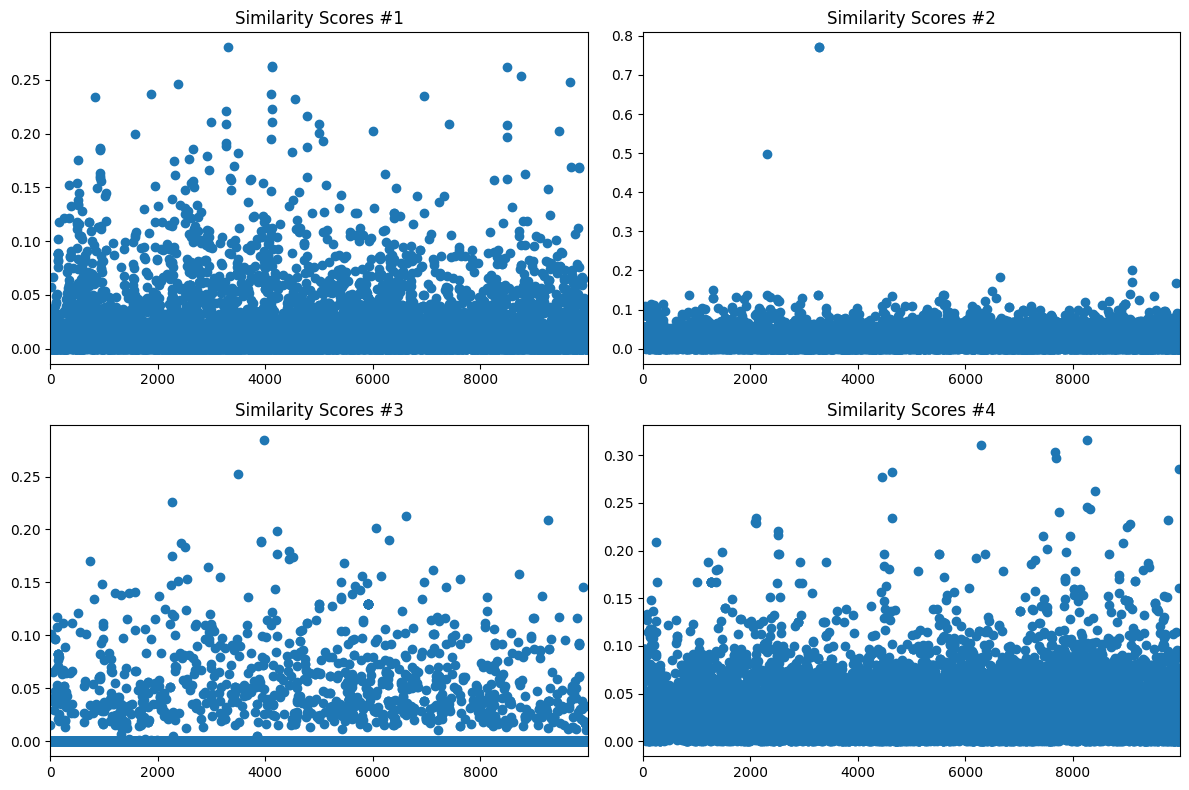

In [305]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterar a través de los 4 resultados y graficarlos en subplots separados
for i in range(4):
    scores_df = pd.DataFrame(similaridad_score_resultados[i], columns=['ItemID', 'Score'])
    ax = axs[i // 2, i % 2]  # Seleccionar el subplot adecuado
    ax.scatter(scores_df['ItemID'], scores_df['Score'])
    ax.set_title(f'Similarity Scores #{i+1}')
    ax.set_xlim(0, scores_df['ItemID'].max())

plt.tight_layout()
plt.show()


In [306]:
# Inicializa listas vacías para almacenar los resultados
final_results = []
# Itera a través de los 4 conjuntos de resultados
for producto in range(4):
    top_scores_product = [similarity_score[1] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_item_ids_product = [similarity_score[0] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_asin_product = asins_resultados[producto][:CANTIDAD]

    # Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
    data = list(zip(top_asin_product, top_scores_product, top_item_ids_product))

    # Crear un DataFrame a partir de los datos combinados
    df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

    # Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
    final_result = pd.merge(df_result, overall_mean, on='asin')
    final_results.append(final_result)



## MODULO 4
### Sistema de inferencia difuso

In [307]:
# Definimos las variables de entrada y salida para el sistema de control difuso
overall = ctrl.Antecedent(np.arange(1, 6, 0.1), 'overall')  # Calificación general
similaridad = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'similaridad')  # Similaridad con otros elementos
recomendacion = ctrl.Consequent(np.arange(0, 2, 0.1), 'recomendacion')  # Recomendación resultante

# Definimos los trapecios para las variables de entrada y salida
overall['excelente'] = fuzz.trapmf(overall.universe, [4.1, 5, 5, 5]) # si el valor es [4.1 o 5], entonces es excelente
overall['bueno'] = fuzz.trapmf(overall.universe, [3.1, 4, 4, 4.1]) # si el valor es [3.1 o 4.1), entonces es bueno
overall['normal'] = fuzz.trapmf(overall.universe, [2.1, 3, 3, 3.1]) # si el valor es [2.1 o 3.1), entonces es normal
overall['pesimo'] = fuzz.trapmf(overall.universe, [0.99, 2, 2, 2.1]) # si el valor es (0.99 o 2.1), entonces es pesimo

similaridad['muy_similar'] = fuzz.trapmf(similaridad.universe, [0.7, 1, 1, 1]) # si el valor es [0.7 o 1], entonces es muy similar
similaridad['similar'] = fuzz.trapmf(similaridad.universe, [0.4, 0.7, 0.7, 0.7]) # si el valor es [0.4 o 0.7), entonces es similar
similaridad['poco_similar'] = fuzz.trapmf(similaridad.universe, [0.2, 0.4, 0.4, 0.4]) # si el valor es [0.2 o 0.4), entonces es poco similar
similaridad['no_similar'] = fuzz.trapmf(similaridad.universe, [-1, 0, 0, 0.2])  # si el valor es [-1 o 0.2), entonces es no similar


recomendacion['muy_recomendado'] = fuzz.trapmf(recomendacion.universe, [1.1, 2, 2, 2]) # si el valor es [1.1 o 2], entonces es muy recomendado
recomendacion['recomendado'] = fuzz.trapmf(recomendacion.universe, [0.1, 1, 1, 1.1]) # si el valor es [0.1 o 1.1), entonces es recomendado
recomendacion['no_recomendado'] = fuzz.trapmf(recomendacion.universe, [0, 0, 0, 0.1]) # si el valor es [0 o 0.1), entonces es no recomendado

# regla 1: si la similaridad es no similar y el overall es excelente, bueno, normal o pesimo, entonces la recomendacion es no recomendado
rule1 = ctrl.Rule(similaridad['no_similar'] & (overall['excelente'] | overall['bueno'] | overall['normal'] | overall['pesimo']), recomendacion['no_recomendado'])
# regla 2: si la similaridad es muy similar, similar, poco similar o no similar y el overall es pesimo, entonces la recomendacion es no recomendado
rule2 = ctrl.Rule(overall['pesimo'] & (similaridad['muy_similar'] | similaridad['similar'] | similaridad['poco_similar'] | similaridad['no_similar']), recomendacion['no_recomendado'])
# regla 3: si la similaridad es muy similar o similar y el overall es excelente o bueno, entonces la recomendacion es muy recomendado
rule3 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['muy_recomendado'])
# regla 4: si la similaridad es muy similar o similar y el overall es normal, entonces la recomendacion es recomendado
rule4 = ctrl.Rule(overall['normal']  & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['recomendado'])
# regla 5: si la similaridad es muy similar o similar y el overall es excelente o bueno y poco similar, entonces la recomendacion es recomendado
rule5 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['poco_similar']), recomendacion['recomendado'])
# regla 6: si la similaridad es poco similar y el overall es normal, entonces la recomendacion es no recomendado
rule6 = ctrl.Rule(overall['normal'] & similaridad['poco_similar'], recomendacion['no_recomendado'])

# Sistema de control y simulación
sistema_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_simulacion = ctrl.ControlSystemSimulation(sistema_control)

testeamos

In [308]:
# Pasar entradas al sistema
sistema_simulacion.input['overall'] = 4  # Ejemplo de calificación
sistema_simulacion.input['similaridad'] = 0.7  # Ejemplo de calificación
sistema_simulacion.compute() # Defuzzificación

# Por el metodo 'centroide'
print(sistema_simulacion.output['recomendacion'])

1.6333333333333335


## MODULO 5
### Defusificador

Defuzzificamos el resultado

In [309]:
def sistema_recomendacion_defuzzificado (recomendacion):
    if recomendacion < 0.1:
        return 'no_recomendado'
    elif recomendacion < 1.1:
        return 'recomendado'
    else:
        return 'muy_recomendado'
    

In [310]:
def sistema_recomendacion( similarity, overall):
    sistema_simulacion.input['overall'] = overall  # Ejemplo de calificación
    sistema_simulacion.input['similaridad'] = similarity # Ejemplo de calificación
    sistema_simulacion.compute() # Defuzzificación
    return (sistema_recomendacion_defuzzificado(sistema_simulacion.output['recomendacion']),sistema_simulacion.output['recomendacion'] )

In [311]:
# Itera a través de los 4 conjuntos de resultados

for i in range(4):
   # Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
    final_results[i]['result'] = final_results[i].apply(lambda row: sistema_recomendacion(row['Score'], row['overall']), axis=1) 

# Para mostrar el DataFrame resultante
for i, df_result in enumerate(final_results):
    sorted_results = final_results[i].sort_values(by='result', key=lambda x: x.apply(lambda y: y[1] if isinstance(y, tuple) else y), ascending=False)




In [313]:
for i in range(4):
    producto_encontrado = df_meta_cortado.loc[df_meta_cortado['asin'] == random_asin_valores[i], ['asin', 'title', 'description']] 
    print("Producto seleccionado: ")
    display(producto_encontrado)
    resultado_completo = pd.merge(final_results[i], df_meta_cortado, on='asin')[['asin', 'title', 'description', 'result']]
    print("Productos recomendados:")
    display(resultado_completo.head(5))


Producto seleccionado: 


,asin,title,description
17181,B0096DI17Q,"handmade rhodium seed beads necklace, Santeria...","[hand made beaded necklace, green and black be..."


Productos recomendados:


,asin,title,description,result
0,B005IM1572,Pugster Believe 925 Sterling Silver Believe In...,[Our Believe Believe In You European Bead is m...,"(recomendado, 0.5991563255241156)"
1,B0081K27AW,"Gold-plated round beads (3mm, 100 beads)",[The round beads are made of gold-plated brass...,"(recomendado, 0.5987578822704156)"
2,B0081K23E2,"Amethyst glass faceted round beads (6mm, 12 in...",[12 inch strand. The faceted round beads are m...,"(recomendado, 0.5987400177319178)"
3,B00SLGRR7O,Qiji Statement Handmade Necklace Elegant Costu...,[The collection is handmade styles with vary k...,"(recomendado, 0.5987395608091959)"
4,B00U5KNS7M,Nuptse Sparkly Silver and Electric Blue Handma...,[A beautiful bracelet set featuring three colo...,"(recomendado, 0.5984722804676588)"


Producto seleccionado: 


,asin,title,description
35345,B00H589AEW,Stetson Elk Horn Wool Cowboy Hat,[The Stetson Elk Horn Crushable Wool Felt Hat ...


Productos recomendados:


,asin,title,description,result
0,B005GKDL9G,Stetson Men's Bozeman Wool Felt Crushable Cowb...,[The Stetson Bozeman Crushable Wool Felt Hat f...,"(muy_recomendado, 1.5622353223103496)"
1,B005GKDL8W,Stetson Men's Bozeman Wool Felt Crushable Cowb...,[The Stetson Bozeman Crushable Wool Felt Hat f...,"(muy_recomendado, 1.5622353223103496)"
2,B003WYFH8G,M / Black,"[Features:* Crushable Hat* 3"" Brim* Water Repe...","(recomendado, 0.9999602701628987)"
3,B00WTSLPQO,M&F Western Unisex Twister Wool Cowboy Hat w/F...,[The M&F Western™ Twister Wool Cowboy Hat w/ F...,"(no_recomendado, 0.04978959551425497)"
4,B00IPS7F20,Pink Cowboy Cowgirl Tiara Felt Light up Prince...,[Perfect for your next rodeo or western-themed...,"(no_recomendado, 0.04785961534213451)"


Producto seleccionado: 


,asin,title,description
52499,B00LW85T6Y,Maltese Cross Pocket Watch,[Maltese Cross Pocket Watch]


Productos recomendados:


,asin,title,description,result
0,B007JRMN0M,Gold Horse Pocket Watch Necklace Watch Quartz ...,[Package contents: 1x GOLD HORSE POCKET WATCH],"(recomendado, 0.5992191939543055)"
1,B005WP28OE,York Rite Maltese Malta Cross Masonic Freemaso...,[This lapel pin is made of the best quality ma...,"(recomendado, 0.5984383131721449)"
2,B003TOEWL2,Sterling Silver Cross Necklace,[This necklace features a cross design and a s...,"(recomendado, 0.5979244747157568)"
3,B00IMC5E7M,Antique Necklace-style Pocket Quartz Watch wit...,[This item is Antique Necklace-style Pocket Qu...,"(recomendado, 0.6130117349786234)"
4,B00XWXPQDI,Spiral Galaxy Necklace Outer Space Milky Way A...,[material alloy Measurements: watch: 40mm diam...,"(no_recomendado, 0.048835760639137665)"


Producto seleccionado: 


,asin,title,description
95007,B00YPZC8DS,Boys Hero Beanie Hat - Red - Knit Winter Kids ...,[FAST SHIPPING - FUNKY & FUN KNIT WINTER SKI H...


Productos recomendados:


,asin,title,description,result
0,B00QW28K02,Sidecca Winter Knit Stripe Slouchy Beanie Hat-...,[Unisex Warm Chunky Ribbed Cable Knit Beanie S...,"(recomendado, 0.5995902838747502)"
1,B00GZLCC90,ArRord Braided Women Lady Warm Rageared Baggy ...,[ArRord Braided Women Lady Warm Rageared Baggy...,"(recomendado, 0.6027713027713024)"
2,B00NM9KK1U,PanDaDa Baby Boys Winter Hats Caps Hat Beanie ...,[Urparcel Baby Boys Earflap Hats Winter Cap Ha...,"(recomendado, 0.6916642228533213)"
3,B00NP254JW,Unisex Ski Wacky Beard Knit Winter Hat Beanie,"[Soft and comfortable, protect you from cold w...","(recomendado, 0.6868499294224806)"
4,B0149GU5HI,Red White Pom Pom Cuff Knit Beanie Hat,[Our Red White Pom Pom Beanie is a classic bea...,"(recomendado, 0.6777112168601196)"
